# Introduction to Optimal Transport with Python

#### *Rémi Flamary, Nicolas Courty*

## POT installation

+ Install with pip:
```bash
pip install pot
```
+ Install with conda
```bash
conda install -c conda-forge pot
```

## POT Python Optimal Transport Toolbox

#### Import the toolbox

In [1]:
import numpy as np # always need it
import scipy as sp # often use it
import pylab as pl # do the plots

import ot # ot 

#### Getting help

Online  documentation : [http://pot.readthedocs.io](http://pot.readthedocs.io) 

Or inline help:


In [2]:
help(ot.dist)

Help on function dist in module ot.utils:

dist(x1, x2=None, metric='sqeuclidean')
    Compute distance between samples in x1 and x2 using function scipy.spatial.distance.cdist
    
    Parameters
    ----------
    
    x1 : np.array (n1,d)
        matrix with n1 samples of size d
    x2 : np.array (n2,d), optional
        matrix with n2 samples of size d (if None then x2=x1)
    metric : str, fun, optional
        name of the metric to be computed (full list in the doc of scipy),  If a string,
        the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock',
        'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski',
        'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    
    
    Returns
    -------
    
    M : np.array (n1,n2)
        distance matrix computed with given metric



## First OT Problem

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in a City (In this case Manhattan). We did a quick google map search in Manhattan for bakeries and Cafés:

![bak.png](https://remi.flamary.com/cours/otml/bak.png)

We extracted from this search their positions and generated fictional production and sale number (that both sum to the same value).

We have acess to the position of Bakeries ```bakery_pos``` and their respective production ```bakery_prod``` which describe the source distribution. The Cafés where the croissants are sold are defiend also by their position ```cafe_pos``` and ```cafe_prod```. For fun we also provide a map ```Imap``` that will illustrate the position of these shops in the city.


Now we load the data



In [3]:
data=np.load('data/manhattan.npz')

bakery_pos=data['bakery_pos']
bakery_prod=data['bakery_prod']
cafe_pos=data['cafe_pos']
cafe_prod=data['cafe_prod']
Imap=data['Imap']

print('Bakery production: {}'.format(bakery_prod))
print('Cafe sale: {}'.format(cafe_prod))
print('Total croissants : {}'.format(cafe_prod.sum()))

Bakery production: [31. 48. 82. 30. 40. 48. 89. 73.]
Cafe sale: [82. 88. 92. 88. 91.]
Total croissants : 441.0


#### Plotting bakeries in the city

Next we plot the position of the bakeries and cafés on the map. The size of the circle is proportional to their production.


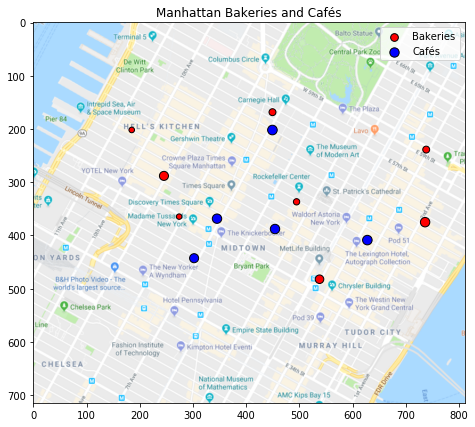

In [4]:

pl.figure(1,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
pl.legend()
pl.title('Manhattan Bakeries and Cafés');


#### Cost matrix


We compute the cost matrix between the bakeries and the cafés, this will be the transport cost matrix. This can be done using the [ot.dist](http://pot.readthedocs.io/en/stable/all.html#ot.dist) that defaults to squared euclidean distance but can return other things such as cityblock (or manhattan distance). 



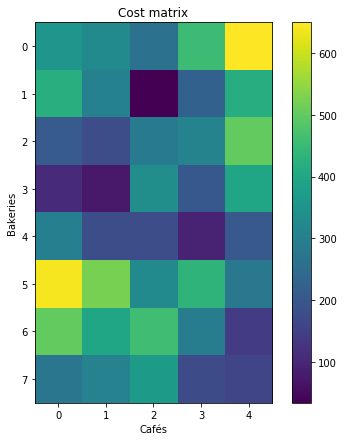

In [5]:
C=ot.dist(bakery_pos,cafe_pos,'sqeuclidean')
C=ot.dist(bakery_pos,cafe_pos,'cityblock')
pl.figure(3,(7,7))
pl.imshow(C);
pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.title('Cost matrix')
pl.colorbar();


#### Solving the OT problem with [ot.emd](http://pot.readthedocs.io/en/stable/all.html#ot.emd)

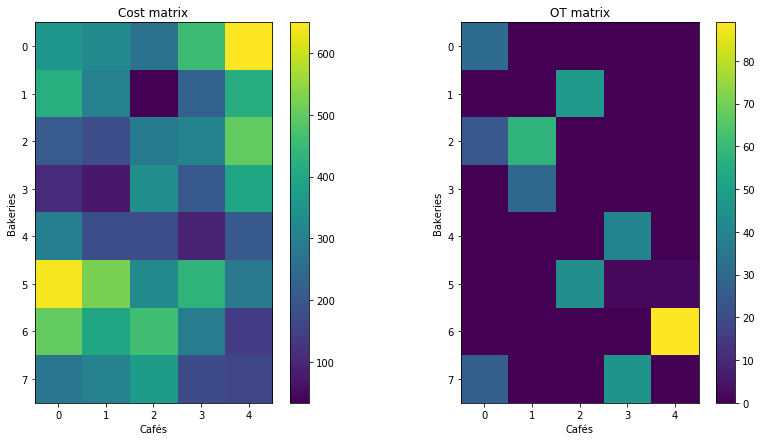

In [6]:
G=ot.emd(bakery_prod,cafe_prod,C)

pl.figure(4,(14,7))

pl.subplot(1,2,1)
pl.imshow(C);
pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.title('Cost matrix')
pl.colorbar();


pl.subplot(1,2,2)
pl.imshow(G);
pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.title('OT matrix')
pl.colorbar();

#np.abs(G-G2).max()

#### Transportation plan vizualization

A good vizualization of the OT matrix in the 2D plane is to denote the transportation of mass between a Bakery and a Café by a line. This can easily be done with a double ```for``` loop.

In order to make it more interpretable one can also use the ```alpha``` parameter of plot and set it to ```alpha=G[i,j]/G[i,j].max()```. 

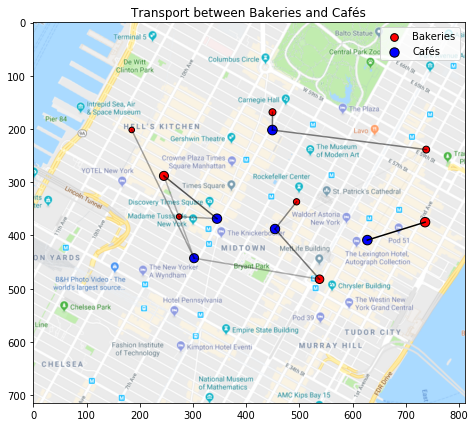

In [7]:
thr=0.1
mx=G.max()
pl.figure(5,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        if G[i,j]>thr:
            pl.plot([bakery_pos[i,0],cafe_pos[j,0]],[bakery_pos[i,1],cafe_pos[j,1]],'k',alpha=G[i,j]/mx)
        
pl.legend()
pl.title('Transport between Bakeries and Cafés');

#### OT loss and dual variables

The resulting wasserstein loss loss is of the form:

$W=\sum_{i,j}\gamma_{i,j}C_{i,j}$

where $\gamma$ is the optimal transport matrix.


In [8]:
loss=np.sum(C*G)

loss

78182.33579594061

#### Regularized OT with SInkhorn

The Sinkhorn algorithm is very simple to code. You can implement it directly using the following pseudo-code:

![sinkhorn.png](http://remi.flamary.com/cours/otml/sink.png)

An alternative is to use the POT toolbox with [ot.sinkhorn](http://pot.readthedocs.io/en/stable/all.html#ot.sinkhorn)

Be carefull to numerical problems. A good pre-provcessing for Sinkhorn is to divide the cost matrix ```C```
 by its maximum value.

77749.04655154662

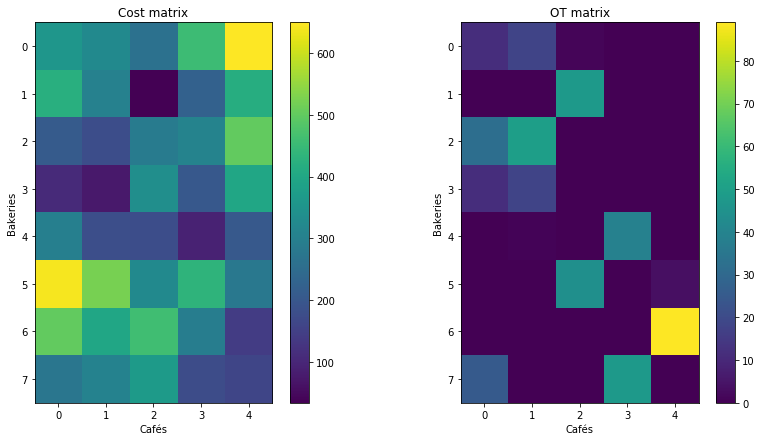

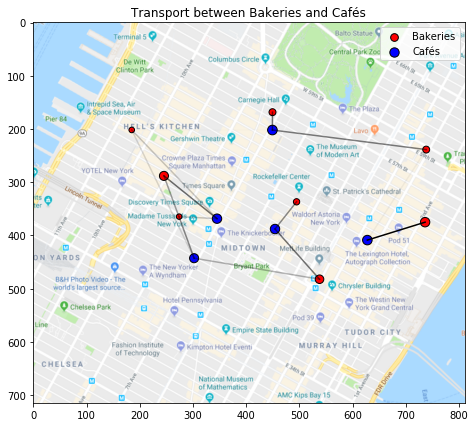

In [9]:
reg=1e-2

C0=C/C.max()

#G0=ot.sinkhorn(bakery_prod,cafe_prod,C0,reg)

K=np.exp(-C0/reg)
G=K
niter=100
u=np.ones(C.shape[0])
for i in range(niter):
    v=cafe_prod/K.T.dot(u)
    u=bakery_prod/K.dot(v)
G=u[:,None]*K*v[None,:]

loss=np.sum(C*G)



pl.figure(4,(14,7))

pl.subplot(1,2,1)
pl.imshow(C);
pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.title('Cost matrix')
pl.colorbar();


pl.subplot(1,2,2)
pl.imshow(G);
pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.title('OT matrix')
pl.colorbar();


thr=0.1
mx=G.max()
pl.figure(5,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        if G[i,j]>thr:
            pl.plot([bakery_pos[i,0],cafe_pos[j,0]],[bakery_pos[i,1],cafe_pos[j,1]],'k',alpha=G[i,j]/mx)
        
pl.legend()
pl.title('Transport between Bakeries and Cafés');
#np.abs(G-G2).max()

loss